# Setup and Imports

- **TensorFlow**: Used for building models with the Keras API (`tensorflow.keras`).
- **Numpy**: For numerical operations and reproducibility (`np.random.seed`).
- **Pandas**: For data manipulation and analysis with DataFrames.
- **Scikit-learn**: `StandardScaler` for feature normalization.
- **JSON**: For handling JSON file operations.
- **Matplotlib**: For plotting and visualization tasks.


## 1. Model Choice
The recommendation system combines various powerful techniques: Siamese Networks, Matrix Factorization, and a Variational Autoencoder (VAE). This choice helps balance the representation learning for users and games and capture latent factors effectively.

- **Siamese Network**: By using the Siamese architecture, we can encode both users and games separately while learning relationships through a shared decoder. This is effective in collaborative filtering problems, where user-game interactions are sparse, and we need to project both users and games into a common embedding space.

- **Matrix Factorization**: This component decomposes the user-game interaction matrix into latent factors. It efficiently learns a low-dimensional embedding of users and games, capturing their collaborative patterns. Matrix Factorization is proven to work well in recommendation systems by revealing hidden relationships between users and items.

- **Game & User Encoders**: These encoders capture more detailed features related to games and users (e.g., playtime, achievements, global features). The additional layers allow the model to handle richer feature sets and capture non-linear relationships between users and games.

- **Decoder**: The decoder fuses the user and game embeddings to predict interaction scores. This design enables the model to adapt to different levels of interaction between users and games.

- **Variational Autoencoder (VAE)**: The VAE adds another layer of learning user representations in a probabilistic latent space, allowing it to model uncertainties or variations in user preferences. VAEs are useful when working with sparse and noisy data, as they can help generalize better by learning distributions over the latent factors.

## 2. Loss Function
The loss functions I’ve chosen reflect the dual goals of the model:

- **Mean Squared Error (MSE)**: This is used as the main loss function in the SiameseRecommendationModel. Since we are predicting the  scores, MSE is appropriate because it penalizes large deviations between the predicted score and the actual value, ensuring that the model learns fine-grained adjustments.

- **VAE Loss**: In the VAE model, I have used a combination of Reconstruction Loss and KL Divergence:
  - **Reconstruction Loss (MSE)**: This ensures that the model can reconstruct the original input (user preferences) from the latent space, improving the quality of the learned embeddings.
  - **KL Divergence**: This encourages the learned latent distribution to be close to a standard normal distribution, which regularizes the model and prevents overfitting by limiting the flexibility of the latent space.

This combination of loss functions encourages the model to learn compact and meaningful representations of user preferences while reconstructing them accurately.

## 3. Model Architecture Design
The model is designed in a way that effectively balances user-game interaction and feature encoding:

- **Embedding Layers**: The embedding layers map discrete user and game IDs into continuous latent spaces. This is crucial for collaborative filtering, as it allows the model to generalize across users and games even if they have not been seen frequently in the data.

- **User & Game Features**: By incorporating both game features (e.g., playtime, achievements) and global features (e.g., genres, platforms), I create a hybrid recommendation system that takes into account both collaborative filtering (user-game interactions) and content-based filtering (game and user features). This enables the model to recommend games more effectively, especially for users with limited interaction data.

- **Reparameterization Trick in VAE**: The reparameterization trick is a core part of the VAE model, allowing the model to backpropagate through the sampling step. This trick ensures that the model can generate meaningful latent variables while keeping the stochastic nature of the latent space.

## 4. Model Justification in Real-World Context
- **Scalability**: By using Matrix Factorization, the model can scale efficiently to large user-game interaction datasets. Since this technique relies on learned embeddings, it can generalize to new users and games without requiring retraining the entire model.

- **Handling Sparsity**: The combination of Matrix Factorization, feature encoders, and VAEs helps handle the data sparsity problem in recommendations. VAEs model uncertainty, while the Siamese structure ensures both user and game embeddings are learned effectively even with fewer interactions.

- **Generalization**: The use of KL Divergence in the VAE encourages smooth latent space learning, which improves generalization, especially when predicting for users or games with sparse interactions. The combined embeddings (MF + encoded features) enhance the model’s ability to recommend across a wide variety of users and games.

- **Personalization**: The Siamese architecture enables personalized recommendations by learning both user and game embeddings. The added encoders allow the model to learn user-specific patterns from features like genres, total playtime, and game diversity, which provide more fine-grained recommendations.

## 5. Conclusion
The model architecture and loss functions chosen are well-suited for a hybrid recommendation system that combines collaborative and content-based filtering. The use of Siamese Networks, Matrix Factorization, and Variational Autoencoders allows the system to effectively model user preferences, handle data sparsity, and scale to large datasets while maintaining a focus on personalization and generalization. The combination of MSE loss for prediction accuracy and KL divergence for regularization ensures the model is both powerful and well-regularized for real-world recommendation tasks.


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import json
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# DataLoader Class

1. **Class Purpose**: The `DataLoader` class is designed to load player statistics from a JSON file.

2. **Attributes**:
   - `file_path`: Path to the JSON file containing player statistics.

3. **Methods**:
   - `__init__(self, file_path)`: Initializes the `DataLoader` with the given file path.
   - `load_data(self)`: 
     - Opens and reads the JSON file.
     - Returns the `playersStats` field from the JSON file.

4. **Output**: Returns the `playersStats` section from the loaded JSON file as a Python dictionary.


In [16]:
class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        with open(self.file_path, 'r') as f:
            data = json.load(f)
        return data["playersStats"]

# DataPreprocessor Class

1. **Class Purpose**: The `DataPreprocessor` class is responsible for preprocessing player and game data for machine learning models, including feature engineering, one-hot encoding, and normalization.

2. **Attributes**:
   - `scaler`: Instance of `StandardScaler` for normalizing numerical features.
   - `ohe`: Instance of `OneHotEncoder` for encoding categorical features.

3. **Methods**:
   - `__init__(self)`: Initializes the `DataPreprocessor` with a `StandardScaler` and `OneHotEncoder`.
   - `preprocess(self, data)`:
     - Processes player and game data.
     - Adds global player features like total playtime and game diversity.
     - One-hot encodes categorical features (genres, platforms, mediums).
     - Normalizes numerical features using the `StandardScaler`.
   - `process_player(self, player_data)`: Extracts and aggregates statistics for each player, including total playtime and genre playtime.
   - `process_game(self, player_id, game)`: Extracts game-specific statistics like playtime, achievements, and last played.
   - `add_global_features(self, df_list, player_id, ...)`: Adds player-level aggregated features to the game-level data.
   - `normalize_features(self, df, genre_set)`: Normalizes numerical features, including genre playtime.
   - `expand_categorical_features(self, df, genre_set, platform_set, medium_set)`: One-hot encodes categorical fields (genres, platforms, mediums).

4. **Output**: Returns a fully preprocessed DataFrame ready for model training.


In [17]:
class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

    def preprocess(self, data):
        df_list = []
        genre_set = set()
        platform_set = set()
        medium_set = set()

        for player_data in data:
            player_id, games, total_playtime_across_games, genre_playtime_dict, games_played,age,friend_type, country, user_interests = self.process_player(player_data)

            for game in games:
                game_data, updated_genres, updated_platforms, updated_mediums = self.process_game(player_id, game)
                game_data['age'] = age
                game_data['friend_type'] = friend_type
                game_data['country'] = country
                game_data['user_interests'] = user_interests
                df_list.append(game_data)
                 
                # Update sets dynamically
                genre_set.update(updated_genres)
                platform_set.update(updated_platforms)
                medium_set.update(updated_mediums)

            # Calculate additional global features for the player
            game_diversity = len(games_played)

            # Add total playtime across all games, total playtime per genre, and game diversity
            self.add_global_features(df_list, player_id, total_playtime_across_games, genre_playtime_dict, genre_set, game_diversity)

        df = pd.DataFrame(df_list)
        df.fillna(0, inplace=True)
        
        pd.set_option('display.max_columns', None)
        display(df)
        
        # One-hot encode categorical columns
        df = self.expand_categorical_features(df, genre_set, platform_set, medium_set)
        
        # Normalize numerical features
        df = self.normalize_features(df, genre_set)
        return df
    
    def calculate_age(self, dob):
        """Calculates age based on DOB."""
        if dob is None:
            return None
        from datetime import datetime
        today = datetime.today()
        birth_date = datetime.strptime(dob, '%Y-%m-%d')
        age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
        return age


    def process_player(self, player_data):
        player_id = player_data['userId']
        games = player_data['games']
        player_summary = player_data.get('playerSummary', {})
        dob = player_summary.get('dob', None)
        age = self.calculate_age(dob) if dob else None
        friend_type = player_summary.get('friend_type', 'beginner')
        country = player_summary.get('country', '')
        user_interests = player_summary.get('user_interests', [])

        
        # Initialize variables for calculating total playtime and game diversity
        total_playtime_across_games = 0
        genre_playtime_dict = {}
        games_played = set()

        for game in games:
            playtime_forever = game['playtime_forever']
            genres = [g['description'] for g in game['details']['genres']]

            # Update total playtime across all games
            total_playtime_across_games += playtime_forever

            # Update total playtime per genre
            for genre in genres:
                if genre not in genre_playtime_dict:
                    genre_playtime_dict[genre] = 0
                genre_playtime_dict[genre] += playtime_forever

            # Track game diversity (number of distinct games played)
            games_played.add(game['appid'])
        
        return player_id, games, total_playtime_across_games, genre_playtime_dict, games_played,age,friend_type, country, user_interests

    def process_game(self, player_id, game):
        """Processes individual game data and returns a dictionary of game statistics."""
        game_id = game['appid']
        game_name = game['name']
        playtime_forever = game['playtime_forever']
        achievements_unlocked = sum([ach['achieved'] for ach in game['achievements']])
        num_sessions = len(game['achievements'])  # Assuming each achievement is a session
        
        genres = [g['description'] for g in game['details']['genres']]
        platforms = [platform for platform, supported in game['details']['platforms'].items() if supported]
        mediums = [cat['description'] for cat in game['details']['categories']]
        last_played = game.get('rtime_last_played', 0)
        
        return {
            'player_id': player_id,
            'game_id': game_id,
            'game_name': game_name,
            'playtime_forever': playtime_forever,
            'achievements_unlocked': achievements_unlocked,
            'num_sessions': num_sessions,
            'genres': genres,
            'platforms': platforms,
            'medium': mediums,
            'last_played': last_played  
        }, genres, platforms, mediums

    def add_global_features(self, df_list, player_id, total_playtime_across_games, genre_playtime_dict, genre_set, game_diversity):
        """Adds global player features such as total playtime, genre playtime, and game diversity."""
        for game_data in df_list:
            if game_data['player_id'] == player_id:
                game_data['total_playtime_across_games'] = total_playtime_across_games
                for genre in genre_set:
                    game_data[f'total_playtime_per_genre_{genre}'] = genre_playtime_dict.get(genre, 0)
                game_data['game_diversity'] = game_diversity

    def normalize_features(self, df, genre_set):
        """Normalizes numerical features using a scaler."""
        numerical_features = ['playtime_forever', 'achievements_unlocked', 'num_sessions', 'total_playtime_across_games', 'game_diversity', 'last_played']
        genre_playtime_columns = [f'total_playtime_per_genre_{genre}' for genre in genre_set]
        
        df[numerical_features + genre_playtime_columns] = self.scaler.fit_transform(df[numerical_features + genre_playtime_columns])
        return df

    def expand_categorical_features(self, df, genre_set, platform_set, medium_set):
        # One-hot encode genres, platforms, and mediums
        for genre in genre_set:
            df[f'genres_{genre}'] = df['genres'].apply(lambda x: 1 if genre in x else 0)

        for platform in platform_set:
            df[f'platforms_{platform}'] = df['platforms'].apply(lambda x: 1 if platform in x else 0)

        for medium in medium_set:
            df[f'medium_{medium}'] = df['medium'].apply(lambda x: 1 if medium in x else 0)

        # Drop original list columns after one-hot encoding
        df = df.drop(columns=['genres', 'platforms', 'medium'])
        assert not df.isnull().any().any(), "Data contains NaN values."
        return df

# MappingLayer Class

1. **Class Purpose**: The `MappingLayer` class is used to create mappings between user and game IDs and their corresponding index values for use in models or other processes.

2. **Attributes**:
   - `user_id_mapping`: Maps `player_id` to unique integer indices.
   - `game_id_mapping`: Maps `game_id` to unique integer indices.
   - `reverse_user_id_mapping`: Maps indices back to `player_id`.
   - `reverse_game_id_mapping`: Maps indices back to `game_id`.

3. **Methods**:
   - `__init__(self, df)`: Initializes mappings for `player_id` and `game_id` based on the unique values in the DataFrame.
   - `map_user_id(self, user_id)`: Returns the mapped index for a given `user_id`. Returns `None` if not found.
   - `map_game_id(self, game_id)`: Returns the mapped index for a given `game_id`. Returns `None` if not found.
   - `reverse_map_user_id(self, idx)`: Returns the `player_id` for a given index. Returns `None` if not found.
   - `reverse_map_game_id(self, idx)`: Returns the `game_id` for a given index. Returns `None` if not found.

4. **Output**: Provides mappings and reverse mappings for user and game IDs, facilitating efficient lookups.


In [18]:
class MappingLayer:
    def __init__(self, df):
        self.user_id_mapping = {user_id: idx for idx, user_id in enumerate(df['player_id'].unique())}
        self.game_id_mapping = {game_id: idx for idx, game_id in enumerate(df['game_id'].unique())}
        
        # Add reverse mappings
        self.reverse_user_id_mapping = {idx: user_id for user_id, idx in self.user_id_mapping.items()}
        self.reverse_game_id_mapping = {idx: game_id for game_id, idx in self.game_id_mapping.items()}

    def map_user_id(self, user_id):
        return self.user_id_mapping.get(user_id, None)  # Return None if user_id is not found

    def map_game_id(self, game_id):
        return self.game_id_mapping.get(game_id, None)  # Return None if game_id is not found

    def reverse_map_user_id(self, idx):
        return self.reverse_user_id_mapping.get(idx, None)  # Return None if index is not found

    def reverse_map_game_id(self, idx):
        return self.reverse_game_id_mapping.get(idx, None)  # Return None if index is not found

# DatasetPreparer Class

1. **Class Purpose**: The `DatasetPreparer` class prepares data for TensorFlow models by splitting it into features and labels, creating input tensors, and batching the data for efficient training.

2. **Attributes**:
   - `batch_size`: Specifies the batch size for training, default is 32.

3. **Methods**:
   - `__init__(self, batch_size=32)`: Initializes with a given batch size.
   - `create_input_tensors(self, df, mapping_layer)`:
     - Converts `player_id` and `game_id` to mapped indices.
     - Extracts game and global features (one-hot encoded genres, platforms, mediums, etc.).
     - Ensures labels (playtime) are valid.
   - `prepare_tf_dataset(self, df, mapping_layer)`:
     - Creates a TensorFlow dataset from input tensors and labels, batching it by the specified size.

4. **Output**: Returns a batched TensorFlow dataset ready for model training.

5. **Input Tensor Creation**: Combines user IDs, game IDs, game features, and global features for model inputs.


In [19]:
class DatasetPreparer:
    def __init__(self, batch_size=32):
        self.batch_size = batch_size

    def create_input_tensors(self, df, mapping_layer):
        # User ID (mapped to internal index)
        user_id = df['player_id'].map(mapping_layer.user_id_mapping).values.astype(np.int32)

        # Game ID (mapped to internal index)
        game_id = df['game_id'].map(mapping_layer.game_id_mapping).values.astype(np.int32)

        # Game features (including last_played)
        game_features = df[['playtime_forever', 'achievements_unlocked', 'num_sessions', 'last_played']].values.astype(np.float32)

        # Global features (one-hot encoded genres, platforms, mediums, total playtime, and game diversity)
        genre_columns = [col for col in df.columns if col.startswith('genres_')]
        platform_columns = [col for col in df.columns if col.startswith('platforms_')]
        medium_columns = [col for col in df.columns if col.startswith('medium_')]
        genre_playtime_columns = [col for col in df.columns if col.startswith('total_playtime_per_genre_')]

        global_features = df[genre_columns + platform_columns + medium_columns + genre_playtime_columns + 
                            ['total_playtime_across_games', 'game_diversity']].values.astype(np.float32)

        labels = df['playtime_forever'].values.astype(np.float32)  # Using total playtime as the label

        assert np.all(np.isfinite(df['playtime_forever'].values)), "Labels contain NaN or Inf values."
        return (user_id, game_id, game_features, global_features), labels
    
    def prepare_tf_dataset(self, df, mapping_layer):
        inputs, labels = self.create_input_tensors(df, mapping_layer)
        dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
        return dataset.batch(self.batch_size)

# VAE Class

1. **Class Purpose**: The `VAE` class defines a Variational Autoencoder model for collaborative filtering, designed to learn latent representations of users and games.

2. **Attributes**:
   - `num_users`: The number of users.
   - `num_games`: The number of games.
   - `embedding_dim`: The dimensionality of the latent space (user and game embeddings).

3. **Components**:
   - **Encoder**:
     - A fully connected layer with 128 units and ReLU activation.
     - Two output layers: 
       - `mu`: Mean of the latent variable.
       - `log_var`: Log variance for reparameterization.
   - **Decoder**:
     - A fully connected layer with 128 units and ReLU activation.
     - `output_layer`: A fully connected layer producing game recommendations using a sigmoid activation to output probabilities.

4. **Methods**:
   - `call(self, user_input)`:
     - **Encoder Pass**: Passes the user input through the encoder, producing mean (`mu`) and log variance (`log_var`) for the latent space.
     - **Reparameterization Trick**: Samples latent vectors (`z`) using the reparameterization trick (`z = mu + ε * exp(0.5 * log_var)`).
     - **Decoder Pass**: Decodes the latent vector (`z`) to reconstruct the original input, predicting game preferences.
   - `vae_loss(self, original, reconstructed, mu, log_var)`:
     - **Reconstruction Loss**: Mean squared error between the original and reconstructed data.
     - **KL Divergence**: Measures the difference between the learned distribution and a unit Gaussian.
     - **Total Loss**: Sum of reconstruction loss and KL divergence to penalize divergence from the prior.

5. **Output**: Returns the reconstructed game preferences, along with `mu` and `log_var` for the latent space.

6. **Loss Function**: The custom loss combines reconstruction error with KL divergence to regularize the latent space for effective learning of user-game interactions.


In [20]:
class VAE(Model):
    def __init__(self, num_users, num_games, embedding_dim):
        super(VAE, self).__init__()
        self.num_users = num_users
        self.num_games = num_games
        self.embedding_dim = embedding_dim

        # Encoder layers
        self.encoder = layers.Dense(128, activation='relu')
        self.mu = layers.Dense(embedding_dim)
        self.log_var = layers.Dense(embedding_dim)

        # Decoder layers
        self.decoder = layers.Dense(128, activation='relu')
        self.output_layer = layers.Dense(num_games, activation='sigmoid')

    def call(self, user_input):
        # Encoder forward pass
        x = self.encoder(user_input)
        mu = self.mu(x)
        log_var = self.log_var(x)

        # Reparameterization trick
        epsilon = tf.random.normal(shape=tf.shape(mu))
        z = mu + tf.exp(0.5 * log_var) * epsilon

        # Decoder forward pass
        x = self.decoder(z)
        reconstructed = self.output_layer(x)

        return reconstructed, mu, log_var

    def vae_loss(self, original, reconstructed, mu, log_var):
        reconstruction_loss = tf.reduce_mean(tf.square(original - reconstructed))
        kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
        return reconstruction_loss + kl_loss

# MatrixFactorization Class

1. **Class Purpose**: The `MatrixFactorization` class implements matrix factorization for collaborative filtering, where both users and games are represented by embeddings, which capture latent factors in a reduced dimensional space.

2. **Attributes**:
   - `num_users`: The total number of unique users in the dataset.
   - `num_games`: The total number of unique games in the dataset.
   - `embedding_dim`: The number of dimensions in the embedding space, defining the latent factor size.

3. **Components**:
   - **User Factors**:
     - An embedding layer that converts user IDs into dense embedding vectors of size `embedding_dim`.
   - **Game Factors**:
     - An embedding layer that converts game IDs into dense embedding vectors of size `embedding_dim`.

4. **Methods**:
   - `call(self, user_input, game_input)`:
     - This method retrieves the embeddings for both users and games based on their input IDs.
     - Returns two sets of embeddings: 
       - `user_embedding`: Dense vectors representing users.
       - `game_embedding`: Dense vectors representing games.

5. **Output**: The embeddings are learned representations of users and games, which can be further used for tasks such as predicting user-game interactions, ratings, or preferences.

In [21]:

class MatrixFactorization(layers.Layer):
    def __init__(self, num_users, num_games, embedding_dim):
        super(MatrixFactorization, self).__init__()
        self.user_factors = layers.Embedding(input_dim=num_users, output_dim=embedding_dim)
        self.game_factors = layers.Embedding(input_dim=num_games, output_dim=embedding_dim)

    def call(self, user_input, game_input):
        user_embedding = self.user_factors(user_input)
        game_embedding = self.game_factors(game_input)
        return user_embedding, game_embedding

# Encoder Class

1. **Class Purpose**: The `Encoder` class defines a neural network encoder that transforms input data into a lower-dimensional embedding space.

2. **Attributes**:
   - `input_dim`: Dimensionality of the input features.
   - `embedding_dim`: Dimensionality of the output embedding.

3. **Components**:
   - **Dense Layer 1**: 
     - A fully connected layer with 128 units and ReLU activation, serving as the initial transformation of the input.
   - **Dense Layer 2**: 
     - A second fully connected layer that reduces the output to `embedding_dim` with ReLU activation.

4. **Methods**:
   - `call(self, inputs)`:
     - Accepts input data and processes it through the two dense layers sequentially.
     - Returns the final embedding.

5. **Output**: The output of the `call` method is an embedding representation of the input data, useful for downstream tasks such as recommendations or clustering.


In [22]:
class Encoder(Model):
    def __init__(self, input_dim, embedding_dim):
        super(Encoder, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(embedding_dim, activation='relu')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return x

# Decoder Class

1. **Class Purpose**: The `Decoder` class defines a neural network decoder that reconstructs output from combined user and game embeddings.

2. **Attributes**:
   - `embedding_dim`: Dimensionality of the input embeddings.

3. **Components**:
   - **Dense Layer 1**: 
     - A fully connected layer with 128 units and ReLU activation, transforming the combined embeddings.
   - **Dense Layer 2**: 
     - A final fully connected layer that outputs a single score per user-game pair.

4. **Methods**:
   - `call(self, user_embedding, game_embedding)`:
     - Accepts user and game embeddings, concatenates them along the last axis, and processes through the dense layers.
     - Returns a single score representing the interaction strength for the user-game pair.

5. **Output**: The output of the `call` method is a tensor of shape `(batch_size, 1)`, indicating the predicted score or interaction for each user-game pair.


In [23]:
class Decoder(Model):
    def __init__(self, embedding_dim):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(1)  # Output a single score per user-game pair

    def call(self, user_embedding, game_embedding):
        combined = tf.concat([user_embedding, game_embedding], axis=-1)
        x = self.dense1(combined)
        x = self.dense2(x)  # Output shape will be (batch_size, 1)
        return x

# SiameseRecommendationModel Class

1. **Class Purpose**: The `SiameseRecommendationModel` class implements a Siamese neural network architecture for personalized recommendations using matrix factorization and encoding techniques.

2. **Attributes**:
   - **Matrix Factorization**: Utilizes `MatrixFactorization` for collaborative filtering based on user and game interactions.
   - **Encoders**: Two separate `Encoder` instances for processing game features and global user features.
   - **Decoder**: A `Decoder` instance to reconstruct the final interaction score from combined embeddings.

3. **Components**:
   - **Matrix Factorization**: Computes user and game embeddings based on interactions.
   - **Game Encoder**: Encodes additional features related to the game.
   - **User Encoder**: Encodes additional features related to the user.
   - **Final Embeddings**: Combines embeddings from matrix factorization and encoders.

4. **Methods**:
   - `call(self, inputs)`:
     - Accepts inputs including user IDs, game IDs, game features, and global user features.
     - Computes final user and game embeddings by summing the outputs of matrix factorization and encoders.
     - Passes combined embeddings to the decoder to produce a score.

5. **Output**: The method returns a tensor of predicted interaction scores, reshaped to remove any singleton dimensions (shape: `(batch_size,)`).


In [24]:
# SiameseRecommendationModel class
class SiameseRecommendationModel(Model):
    def __init__(self, num_users, num_games, embedding_dim):
        super(SiameseRecommendationModel, self).__init__()
        self.matrix_factorization = MatrixFactorization(num_users=num_users, num_games=num_games, embedding_dim=embedding_dim)
        self.game_encoder = Encoder(input_dim=10, embedding_dim=embedding_dim)  
        self.user_encoder = Encoder(input_dim=10, embedding_dim=embedding_dim) 
        self.decoder = Decoder(embedding_dim=embedding_dim)

    def call(self, inputs):
        user_input, game_input, game_features, global_features = inputs
        user_embedding_mf, game_embedding_mf = self.matrix_factorization(user_input, game_input)
        game_embedding_encoded = self.game_encoder(game_features)
        user_embedding_encoded = self.user_encoder(global_features)
        final_user_embedding = user_embedding_mf + user_embedding_encoded
        final_game_embedding = game_embedding_mf + game_embedding_encoded
        score = self.decoder(final_user_embedding, final_game_embedding)
        return tf.squeeze(score, axis=-1)

# ModelTrainer Class

1. **Purpose**: The `ModelTrainer` class handles the compilation and training of the recommendation model with configurable parameters.

2. **Attributes**:
   - **model**: The recommendation model to be trained.
   - **learning_rate**: The step size for updating model weights during training (default: 0.001).
   - **batch_size**: The number of samples per training batch (default: 128).
   - **epochs**: The number of complete passes through the training dataset (default: 65).

3. **Methods**:
   - `compile_model()`: Compiles the model using the Adam optimizer with the specified learning rate and Mean Squared Error (MSE) loss function.
   - `train_model(train_dataset, test_dataset)`: 
     - Compiles the model.
     - Trains the model on the provided training dataset and validates it using the test dataset.
     - Returns the training history, which contains the loss and validation loss per epoch.

4. **Inputs**:
   - **train_dataset**: The dataset used to train the model.
   - **test_dataset**: The dataset used to validate the model during training.

5. **Output**: Returns the training history after completing the specified number of epochs, including training and validation loss metrics for each epoch.


In [25]:
class ModelTrainer:
    def __init__(self, model, learning_rate=0.001, batch_size=128, epochs=65):
        self.model = model
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs

    def compile_model(self):
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss='mean_squared_error')

    def train_model(self, train_dataset, test_dataset):
        self.compile_model()
        history = self.model.fit(train_dataset, validation_data=test_dataset, epochs=self.epochs)
        return history

# RecommendationSystem Class

1. **Class Purpose**: The `RecommendationSystem` class is designed to provide user recommendations for a specific game using a collaborative filtering approach. It integrates a main recommendation model, a Variational Autoencoder (VAE), and a mapping layer for translating between user and game IDs and their corresponding indices.

2. **Attributes**
- **model**: The primary recommendation model.
- **vae_model**: The Variational Autoencoder (VAE) used for learning latent user representations.
- **dataset_preparer**: A utility for preparing input tensors for the model from user-game interaction data.
- **mapping_layer**: A layer responsible for mapping user and game IDs to their internal indices and vice versa.

3. **Methods**

- `recommend_top_users(df, game_id, user_id, num_recommendations=3)`
This method generates the top user recommendations for a given game and user.

- **Inputs**:
  - `df`: A DataFrame containing user-game interaction data.
  - `game_id`: The ID of the game for which user recommendations are generated.
  - `user_id`: The ID of the user requesting recommendations.
  - `num_recommendations` (optional): The number of users to recommend (default: 3).
  
- **Logic**:
  - Maps the `game_id` and `user_id` to their corresponding indices using the `mapping_layer`.
  - Uses the model to predict scores for all users based on the game and user interactions.
  - Excludes the input user from the recommendations by setting their score lower than the minimum score.
  - Sorts users based on predicted scores and returns the top recommendations.
  - Reverse maps the user indices to actual user IDs for the output.
  
- **Output**: Returns a list of top recommended user IDs, excluding the input user.

- `__init__(self, model, vae_model, dataset_preparer, mapping_layer)`
The constructor initializes the `RecommendationSystem` class with:
- `model`: The recommendation model.
- `vae_model`: The VAE model.
- `dataset_preparer`: For creating input tensors for the model.
- `mapping_layer`: For mapping between user and game IDs and their internal indices.

4. **Input Details for `recommend_top_users`**:
- **df**: A DataFrame that contains interaction data between players and games.
- **game_id**: The unique identifier for the game.
- **user_id**: The unique identifier for the user.
- **num_recommendations**: The number of top users to recommend (default is 3).

5. **Output**
- **List of Recommended User IDs**: A list of the recommended users, excluding the input user.


In [26]:
class RecommendationSystem:
    def __init__(self, model, vae_model, dataset_preparer, mapping_layer):
        self.model = model
        self.vae_model = vae_model
        self.dataset_preparer = dataset_preparer
        self.mapping_layer = mapping_layer

    def process_filters(self, df, game_id, country, friend_type, user_interests, age_range=None):
        """Filter the dataframe based on game_id and other filters."""
        # filtered_df = df[df['game_id'] == game_id]
        filtered_df = df
        if country:
            filtered_df = filtered_df[filtered_df['country'] == country]
        
        if friend_type:
            filtered_df = filtered_df[filtered_df['friend_type'] == friend_type]

        if user_interests:
            filtered_df = filtered_df[filtered_df['user_interests'].apply(lambda x: any(interest in x for interest in user_interests))]

        if age_range:
            filtered_df = filtered_df[(filtered_df['age'] >= age_range[0]) & (filtered_df['age'] <= age_range[1])]
        
        return filtered_df

    def recommend_top_users(self, df, game_id, user_id, num_recommendations=3, filters=None):
        # Call process_filters if filters are provided
        if filters:
            df = self.process_filters(
                df, 
                game_id, 
                filters.get('country'), 
                filters.get('friend_type'), 
                filters.get('user_interests'), 
                filters.get('age_range')
            )
        
        if df.empty:
            return []
        
        # Get the mapped index of the game_id and user_id using the mapping layer
        game_idx = self.mapping_layer.map_game_id(game_id)
        user_idx = self.mapping_layer.map_user_id(user_id)

        # If the user_id or game_id is not found, return an empty list
        if game_idx is None or user_idx is None:
            return []

        # Ensure the user_id is not recommended to themselves
        game_input = np.array([game_idx] * len(df['player_id']))  # Replicate the same game index for all users
        user_input = df['player_id'].map(self.mapping_layer.user_id_mapping).values.astype(np.int32)  # Mapped user indices

        # Prepare the game features and global features
        (_, _, game_features, global_features), _ = self.dataset_preparer.create_input_tensors(df, self.mapping_layer)

        # Prepare inputs
        inputs = (user_input, game_input, game_features, global_features)

        # Predict scores for all users
        scores = self.model.predict(inputs)
        
        # Create a dictionary to accumulate scores per user
        user_scores = {}
        for idx, score in enumerate(scores):
            user_id = user_input[idx]
            if user_id in user_scores:
                user_scores[user_id] += score  # Sum the scores for each user
            else:
                user_scores[user_id] = score
        
        print(user_scores)

        # Exclude the user's own score by setting it to a very low value
        if user_idx in user_scores:
            user_scores[user_idx] = np.min(list(user_scores.values())) - 1  # Set it lower than the minimum score

        # Sort the scores to get the top recommendations
        sorted_users = sorted(user_scores.items(), key=lambda x: x[1], reverse=True)

        # Get the top N recommendations (excluding the current user)
        top_user_indices = [user_id for user_id, _ in sorted_users if user_id != user_idx][:num_recommendations]

        # Reverse map indices to actual user IDs
        top_user_ids = [self.mapping_layer.reverse_map_user_id(idx) for idx in top_user_indices]

        return top_user_ids


# Loss Plotting Function

1. **plot_loss** : `plot_loss` function plots training and validation loss from the training history of a Keras model.


In [27]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Main Execution Block

1. **Purpose**: The main execution block is responsible for loading and preprocessing data, creating model instances, training the recommendation system, and generating user recommendations.

2. **Data Loading**:
   - **DataLoader**: Loads player data from a JSON file.
   - `load_data()`: Fetches and flattens the nested JSON data into a DataFrame.

3. **Data Preprocessing**:
   - **DataPreprocessor**: Preprocesses the loaded DataFrame, including mapping player and game IDs and handling categorical features.
   - `preprocess()`: Returns the processed DataFrame, the number of unique users, and the number of unique games.

4. **Dataset Preparation**:
   - **DatasetPreparer**: Prepares the training and testing datasets from the preprocessed data.
   - `prepare_tf_dataset()`: Converts the DataFrame into TensorFlow datasets for training.

5. **Model Creation**:
   - `num_users`: The number of unique users in the dataset.
   - `num_games`: The number of unique games in the dataset.
   - `embedding_dim`: The dimensionality of the embedding layer (set to 50 in this case).
   - `SiameseRecommendationModel`: A model combining matrix factorization and embedding techniques for collaborative filtering.
   - `vae_model`: Variational Autoencoder (VAE) model for learning latent representations (placeholder in the code).

6. **Training**:
   - **ModelTrainer**: Trains the Siamese model with the specified learning rate, batch size, and number of epochs.
   - `train_model()`: Trains the model on the prepared dataset and returns the training history.
   - `train_vae()`: Trains the VAE on user inputs and labels derived from the data

7. **Loss Plotting**:
   - `plot_loss()`: Plots the training loss to visualize the model's learning progress.

8. **Recommendation System**:
   - **RecommendationSystem**: Instantiates a recommendation system using the trained Siamese model, VAE, dataset preparer, and mapping layer.
   - `recommend_top_users()`: Retrieves the top user recommendations for a specific game and user ID.
   - `num_recommendations`: The number of user recommendations to be generated (default: 12).


,player_id,game_id,game_name,playtime_forever,achievements_unlocked,num_sessions,genres,platforms,medium,last_played,age,friend_type,country,user_interests,total_playtime_across_games,total_playtime_per_genre_Indie,total_playtime_per_genre_Action,total_playtime_per_genre_Adventure,game_diversity,total_playtime_per_genre_Strategy
0,4,450,LIMBO,0,0,2,"[Action, Adventure, Indie]","[windows, mac, linux]","[Single-player, Steam Achievements]",0,34,Beginner,Germany,"[MOBA, Strategy]",0,0,0,0,1,0.0
1,5,134,Game-134,3331,2,5,[Indie],[windows],"[Single-player, Steam Achievements]",1039016802,39,Beginner,Brazil,"[RPG, Indie]",9508,4867,0,0,3,4641.0
2,5,752,Game-752,1536,1,2,[Indie],[windows],"[Single-player, Steam Achievements]",1458650453,39,Beginner,Brazil,"[RPG, Indie]",9508,4867,0,0,3,4641.0
3,5,418,Game-418,4641,1,2,[Strategy],[windows],"[Single-player, Steam Achievements]",1025113538,39,Beginner,Brazil,"[RPG, Indie]",9508,4867,0,0,3,4641.0
4,6,629,Game-629,857,0,3,[Adventure],"[mac, linux]","[Single-player, Steam Achievements]",422340676,19,Beginner,Brazil,"[Action, RPG, Indie]",12222,2840,0,3442,5,5940.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5478,1003,494,Game-494,1058,3,5,[Adventure],[linux],"[Single-player, Steam Achievements]",159933368,35,Pro,USA,"[Action, RPG, MOBA]",12189,2692,5987,3510,7,0.0
5479,1003,778,Game-778,2505,3,5,[Indie],[mac],"[Single-player, Steam Achievements]",974937012,35,Pro,USA,"[Action, RPG, MOBA]",12189,2692,5987,3510,7,0.0
5480,1004,855,Game-855,2504,3,3,[Strategy],[mac],"[Single-player, Steam Achievements]",1567867514,36,Intermediate,France,"[MOBA, Action, Indie]",5998,2129,0,0,3,3869.0
5481,1004,669,Game-669,2129,3,3,[Indie],"[windows, linux]","[Single-player, Steam Achievements]",9706943,36,Intermediate,France,"[MOBA, Action, Indie]",5998,2129,0,0,3,3869.0


Epoch 1/65
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1309 - val_loss: 0.0144
Epoch 2/65
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0120 - val_loss: 0.0104
Epoch 3/65
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - val_loss: 0.0326
Epoch 4/65
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - val_loss: 0.0365
Epoch 5/65
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0120 - val_loss: 0.0302
Epoch 6/65
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0236 - val_loss: 0.0805
Epoch 7/65
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0279 - val_loss: 0.0225
Epoch 8/65
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0085 - val_loss: 0.0233
Epoch 9/65
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0072 - val_loss: 0.0429
Epoch 10/65
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0112 - val_loss: 0.0248
Epoch 11/65
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0300 - val_loss: 0.0274
Epoch 12/65
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/st

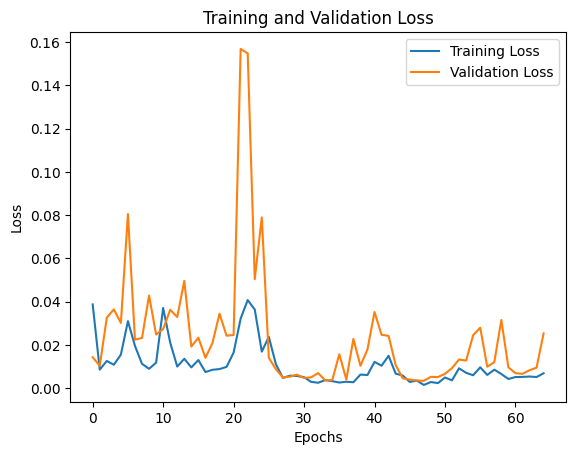

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
{53: 0.9144281, 369: 0.16898057, 686: 5.992035, 983: -1.1242634}
Top recommended users for game 450 and player_id 4: [690, 57]


In [28]:
if __name__ == "__main__":
    
    data_loader = DataLoader('player_data1.json')
    raw_data = data_loader.load_data()

    preprocessor = DataPreprocessor()
    preprocessed_data = preprocessor.preprocess(raw_data)
    
    mapping_layer = MappingLayer(preprocessed_data)

    num_users = len(preprocessed_data['player_id'].unique())
    num_games = len(preprocessed_data['game_id'].unique())
    embedding_dim = 512

    siamese_model = SiameseRecommendationModel(num_users=num_users, num_games=num_games, embedding_dim=embedding_dim)

    vae_model = None  # Replace with the actual VAE model(Will integrate in the second version)
    
    dataset_preparer = DatasetPreparer()

    model_trainer = ModelTrainer(model=siamese_model, learning_rate=0.001, batch_size=128, epochs=65)
    train_dataset = dataset_preparer.prepare_tf_dataset(preprocessed_data, mapping_layer)
    test_dataset = train_dataset  # Replace with actual test dataset
    history = model_trainer.train_model(train_dataset, test_dataset)
    
    plot_loss(history)
    
    recommendation_system = RecommendationSystem(model=siamese_model, vae_model=vae_model, dataset_preparer=dataset_preparer, mapping_layer=mapping_layer)
    
    game_id = 450  
    user_id = 4 
    filters = {
        "game_id": game_id,
        "friend_type": "Beginner",
        "country": "Brazil",
        "user_interests": ["RPG","Indie"],
        "age_range": [30,36] 
    }
    top_users = recommendation_system.recommend_top_users(preprocessed_data, game_id, user_id, num_recommendations=2,filters=filters)

    print(f"Top recommended users for game {game_id} and player_id {user_id}: {top_users}")